Lets first import CIFAR-10 Dataset and see what's going on!

Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


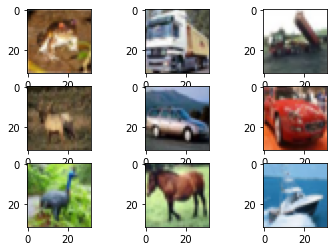

In [1]:
from matplotlib import pyplot
from keras.datasets import cifar10

(trainX, trainY), (testX, testY) = cifar10.load_data()

print('Train: X=%s, y=%s' % (trainX.shape, trainY.shape))
print('Test: X=%s, y=%s' % (testX.shape, testY.shape))


for i in range(9):
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(trainX[i])
pyplot.show()

In [2]:
input_shape = (32,32,3)
output_shape = 10

One-Hot Encoding the Target Value

In [3]:
from keras.utils.np_utils import to_categorical

trainY = to_categorical(trainY)
testY = to_categorical(testY)

Prepare and Normalize Data

In [4]:
trainX = trainX.astype('float32')
testX = testX.astype('float32')

trainX = trainX / 255.0
testX = testX / 255.0

Defining The Convlutional Supervised Autoencoder

In [5]:
from keras.layers import Conv2D, Dense, Input, MaxPooling2D, UpSampling2D, Flatten
from keras import models
from keras.layers.merge import Concatenate

input_img = Input(shape=input_shape)

encode1 = Conv2D(128, (3, 3), activation='relu', padding='same')(input_img)
encode2 = Conv2D(64, (3, 3), activation='relu', padding='same')(encode1)
encode3 = MaxPooling2D((2, 2), padding='same')(encode2)
encode4 = Conv2D(32, (3, 3), activation='relu', padding='same')(encode3)
bottleneck = MaxPooling2D((2, 2), padding='same')(encode4)

decode1 = Conv2D(32, (3, 3), activation='relu', padding='same')(bottleneck)
decode2 = UpSampling2D((2, 2))(decode1)
merge1 = Concatenate()([encode4, decode2])
decode3 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge1)
decode4 = UpSampling2D((2, 2))(decode3)
merge2 = Concatenate()([encode2, decode4])
decode5 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge2)
decode6 = Conv2D(3, (3, 3), activation='relu', padding='same')(decode5)

hidden0 = Flatten()(bottleneck)
# hidden1 = Dense(16, activation='relu')(hidden0)
# hidden2 = Dense(16, activation='relu')(hidden1)
output = Dense(output_shape, activation='softmax')(hidden0)

csae = models.Model(input_img, [decode6, output])

csae.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 128)  3584        ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 64)   73792       ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 16, 16, 64)   0           ['conv2d_1[0][0]']               
                                                                                              

Optimizer Settings

In [6]:
from tensorflow.keras import optimizers
from keras.losses import huber, MSE

learning_rate = 1E-3 # to be tuned!

csae.compile(loss=[MSE,'categorical_crossentropy'], optimizer=optimizers.Adam(lr=learning_rate),metrics=['acc'])

c:\users\mesto\appdata\local\programs\python\python39\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training The Model

In [7]:
history = csae.fit(trainX, [trainX, trainY], 
                   batch_size=64, 
                   epochs=10, 
                   validation_split=0.1)

Epoch 1/10
704/704 [==============================] - 23s 28ms/step - loss: 1.4835 - conv2d_6_loss: 0.0058 - dense_loss: 1.4777 - conv2d_6_acc: 0.7010 - dense_acc: 0.4714 - val_loss: 1.2431 - val_conv2d_6_loss: 0.0024 - val_dense_loss: 1.2407 - val_conv2d_6_acc: 0.7925 - val_dense_acc: 0.5582
Epoch 2/10
704/704 [==============================] - 19s 27ms/step - loss: 1.0803 - conv2d_6_loss: 0.0034 - dense_loss: 1.0769 - conv2d_6_acc: 0.7465 - dense_acc: 0.6255 - val_loss: 1.0275 - val_conv2d_6_loss: 0.0027 - val_dense_loss: 1.0248 - val_conv2d_6_acc: 0.6459 - val_dense_acc: 0.6462
Epoch 3/10
704/704 [==============================] - 19s 27ms/step - loss: 0.9240 - conv2d_6_loss: 0.0037 - dense_loss: 0.9203 - conv2d_6_acc: 0.7448 - dense_acc: 0.6814 - val_loss: 0.9505 - val_conv2d_6_loss: 0.0026 - val_dense_loss: 0.9479 - val_conv2d_6_acc: 0.7369 - val_dense_acc: 0.6720
Epoch 4/10
704/704 [==============================] - 19s 27ms/step - loss: 0.8360 - conv2d_6_loss: 0.0036 - dense_los

Plotting the results

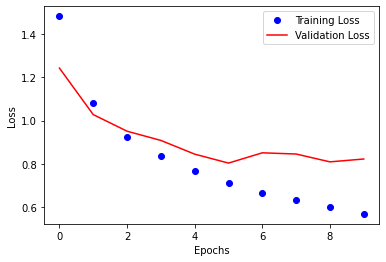

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

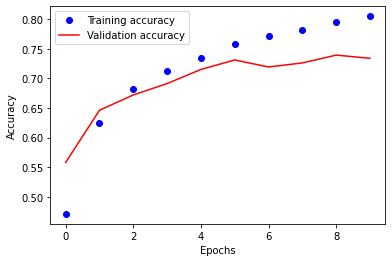

In [9]:
acc = history.history['dense_acc']
val_acc = history.history['val_dense_acc']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Using the encoder for fine-tuning

In [10]:
sae_encoder = models.Model(input_img, bottleneck)
sae_encoder.summary()

bottle_neck_train = sae_encoder.predict(trainX)
bottle_neck_test = sae_encoder.predict(testX)

print('bottle_neck_train:{}'.format(bottle_neck_train.shape))
print('bottle_neck_test:{}'.format(bottle_neck_test.shape))

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 128)       3584      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                       

Build Classifier for fine-tune

In [11]:
input_feat = Input(shape=(8,8,32))

hidden0 = Flatten()(input_feat)
hidden1 = Dense(128, activation='relu')(hidden0)
# hidden2 = Dense(16, activation='relu')(hidden1)
output = Dense(output_shape, activation='softmax')(hidden0)

classifier = models.Model(input_feat, output)

classifier.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 8, 8, 32)]        0         
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 10)                20490     
                                                                 
Total params: 20,490
Trainable params: 20,490
Non-trainable params: 0
_________________________________________________________________


In [12]:
classifier.compile(loss='categorical_crossentropy',optimizer=optimizers.RMSprop(lr=learning_rate),metrics=['acc'])

history = classifier.fit(bottle_neck_train, trainY, 
                        batch_size=64, 
                        epochs=2, 
                        validation_split=0.1)

Epoch 1/2


c:\users\mesto\appdata\local\programs\python\python39\lib\site-packages\keras\optimizer_v2\rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


704/704 [==============================] - 2s 3ms/step - loss: 0.8860 - acc: 0.6961 - val_loss: 0.7739 - val_acc: 0.7364
Epoch 2/2
704/704 [==============================] - 2s 3ms/step - loss: 0.6298 - acc: 0.7859 - val_loss: 0.7642 - val_acc: 0.7502


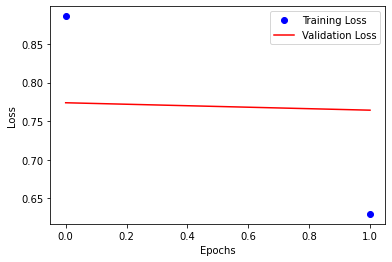

In [13]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

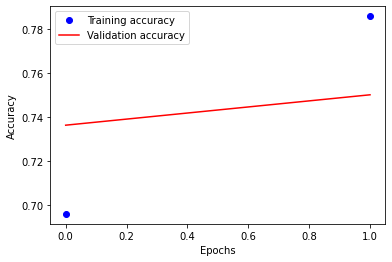

In [14]:
acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [15]:
bottle_neck_test = sae_encoder.predict(testX)
score = classifier.evaluate(bottle_neck_test, testY, verbose=0)
print('e = {} , acc = {}'.format(score[0], score[1]))

e = 0.7754853367805481 , acc = 0.7407000064849854
